## Import Utils

In [1]:
!pip install keras

In [2]:
import keras
import h5py as h5
import numpy as np

PATH_DATA = 'data/train/eightieth.h5'
PATH_PREDICT_WITHOUT_GT = 'data/pred_students/pred_eighties_from_half_1_without_gt.h5'
PATH_SUBMIT_1 = 'test_combine_1.h5'
PATH_SUBMIT_2 = 'test_combine_2.h5'
PATH_SUBMIT_3 = 'test_combine_3.h5'
PATH_SUBMIT_4 = 'test_combine_4.h5'
PATH_SUBMIT_5 = 'test_combine_5.h5'
PATH_PREDICT_WITH_GT = 'data/pred_teachers/pred_eighties_from_half_1.h5'

/usr/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
BATCH_SIZE = 32
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Reshape, Dropout
import keras.layers.normalization 
from keras.callbacks import Callback
%load_ext autoreload
%autoreload 2

In [4]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count

In [5]:
idxs = get_idxs(PATH_DATA)
shuffled_idxs = shuffle_idx(idxs)
train_idxs, val_idxs = split_train_val(shuffled_idxs, 0.2)

In [6]:
import pywt
import cv2


def generator_fft(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = []
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            batch = f['S2'][batch_idxs, :,:,:]
            for bb in range(len(batch)):
                patch = batch[bb,:,:,:]
                fft2 = np.zeros((16,16,4))
                fft2[:,:,0] = np.real(np.fft.fft2(batch[bb,:,:,0]))
                fft2[:,:,1] = np.real(np.fft.fft2(batch[bb,:,:,1]))
                fft2[:,:,2] = np.real(np.fft.fft2(batch[bb,:,:,2]))
                fft2[:,:,3] = np.real(np.fft.fft2(batch[bb,:,:,3]))
                X.append(fft2)
                
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

In [7]:
def generator_dwt(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = []
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            batch = f['S2'][batch_idxs, :,:,:]
            for bb in range(len(batch)):
                patch = batch[bb,:,:,:]
                
                # dwt2 for each chan
                cA0, (cD0, cV0, cH0) = pywt.dwt2(batch[bb,:,:,0], 'haar')
                cA1, (cD1, cV1, cH1) = pywt.dwt2(batch[bb,:,:,1], 'haar')
                cA2, (cD2, cV2, cH2) = pywt.dwt2(batch[bb,:,:,2], 'haar')
                cA3, (cD3, cV3, cH3) = pywt.dwt2(batch[bb,:,:,3], 'haar')
                
                dwt2 = np.zeros((16,16,4))
                dwt2[:,:,0] = np.concatenate((np.concatenate((cA0, cD0), axis=1), np.concatenate((cV0, cH0), axis=1)), axis=0)
                dwt2[:,:,1] = np.concatenate((np.concatenate((cA1, cD1), axis=1), np.concatenate((cV1, cH1), axis=1)), axis=0)
                dwt2[:,:,2] = np.concatenate((np.concatenate((cA2, cD2), axis=1), np.concatenate((cV2, cH2), axis=1)), axis=0)
                dwt2[:,:,3] = np.concatenate((np.concatenate((cA3, cD3), axis=1), np.concatenate((cV3, cH3), axis=1)), axis=0)
                X.append(dwt2)
                
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

In [8]:
def generator_patch(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = []
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            batch = f['S2'][batch_idxs, :,:,:]
            for bb in range(len(batch)):
                patch = batch[bb,:,:,:]
                X.append(patch)
                
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

In [9]:
def generator_hist(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = []
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            batch = f['S2'][batch_idxs, :,:,:]
            for bb in range(len(batch)):
                patch = batch[bb,:,:,:]
                band_normalized = []
                for i in range(4):
                    a = patch[:,:,i].flatten()
                    band_normalized.append((255*((a - np.min(a)) / ( np.max(a) - np.min(a)))).astype(int))
                
                h0, bins = np.histogram(band_normalized[0], bins=range(256))
                h1, bins = np.histogram(band_normalized[1], bins=range(256))
                h2, bins = np.histogram(band_normalized[2], bins=range(256))
                h3, bins = np.histogram(band_normalized[3], bins=range(256))
                h = np.concatenate((h0, h1, h2, h3), axis=0)
                X.append(h)
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

In [10]:
from skimage import feature
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
 
    def describe(self, image, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        lbp = feature.local_binary_pattern(image, self.numPoints,
            self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
            bins=np.arange(0, self.numPoints + 3),
            range=(0, self.numPoints + 2))

        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)

        # return the histogram of Local Binary Patterns
        return hist

def generator_texture(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    desc = LocalBinaryPatterns(32, 12)
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = []
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            batch = f['S2'][batch_idxs, :,:,:]
            for bb in range(len(batch)):
                patch = batch[bb,:,:,:]
                gray = cv2.cvtColor(batch[bb,:,:,:], cv2.COLOR_BGR2GRAY)
                hist = desc.describe(gray)
                X.append(hist)
                
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

In [11]:
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from scipy import ndimage as nd
def generator_gabor(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    # prepare filter bank kernels
    kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for frequency in (0.05, 0.25):
                kernel = np.real(gabor_kernel(frequency, theta=theta,
                                            sigma_x=sigma, sigma_y=sigma))
                kernels.append(kernel)

    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = []
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            batch = f['S2'][batch_idxs, :,:,:]
            for bb in range(len(batch)):
                patch = batch[bb,:,:,:]
                gray = cv2.cvtColor(batch[bb,:,:,:], cv2.COLOR_BGR2GRAY)
                filtered = []
                for i in range(len(kernels)):
                    filtered.append(nd.convolve(gray, kernels[i]))
                
                X.append(filtered)
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

# Modele 1 : patch 

In [12]:
train_gen_patch = generator_patch(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen_patch = generator_patch(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)
print(train_batch_count, val_batch_count)
print(np.shape(train_gen_patch.__next__()[0])) 

5850 1463
(32, 16, 16, 4)


In [13]:
input_shape = (16,16,4)
model_patch = Sequential()
model_patch.add(BatchNormalization(input_shape=input_shape))
model_patch.add(Conv2D(16, kernel_size=(3, 3),activation='relu'))
model_patch.add(Conv2D(32, (3, 3), activation='relu'))
model_patch.add(Conv2D(64, (3, 3), activation='relu'))
model_patch.add(Dropout(0.25))
model_patch.add(Flatten())
model_patch.add(Dense(128, activation='relu'))
model_patch.add(Dropout(0.5))
model_patch.add(Dense(23, activation='softmax'))

model_patch.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_patch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 16, 16, 4)         16        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        592       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               819328    
__________

In [14]:
history_patch = model_patch.fit_generator(train_gen_patch, steps_per_epoch=train_batch_count/BATCH_SIZE, epochs=10, verbose=1, 
                              validation_data=val_gen_patch, validation_steps=val_batch_count/BATCH_SIZE)
model_patch.save_weights(PATH_SUBMIT_1)

Epoch 1/10
183/182 [==============================] - 17s 91ms/step - loss: 1.5080 - acc: 0.4624 - val_loss: 1.2263 - val_acc: 0.5421
Epoch 2/10
183/182 [==============================] - 12s 67ms/step - loss: 1.3120 - acc: 0.5106 - val_loss: 1.2361 - val_acc: 0.5285
Epoch 3/10
183/182 [==============================] - 12s 66ms/step - loss: 1.2828 - acc: 0.5263 - val_loss: 1.2262 - val_acc: 0.5455
Epoch 4/10
183/182 [==============================] - 12s 67ms/step - loss: 1.2609 - acc: 0.5371 - val_loss: 1.1866 - val_acc: 0.5503
Epoch 5/10
183/182 [==============================] - 12s 66ms/step - loss: 1.2368 - acc: 0.5405 - val_loss: 1.1926 - val_acc: 0.5469
Epoch 6/10
183/182 [==============================] - 12s 67ms/step - loss: 1.2578 - acc: 0.5260 - val_loss: 1.1404 - val_acc: 0.5591
Epoch 7/10
183/182 [==============================] - 12s 66ms/step - loss: 1.2539 - acc: 0.5215 - val_loss: 1.1796 - val_acc: 0.5476
Epoch 8/10
183/182 [==============================] - 12s 67ms

In [15]:
score = model_patch.evaluate_generator(val_gen_patch, steps=val_batch_count/BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1646741136260654
Test accuracy: 0.561141304347826


# modele 2 : fft 

In [16]:
train_gen_fft = generator_fft(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen_fft = generator_fft(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)
print(train_batch_count, val_batch_count)
print(np.shape(train_gen_fft.__next__()[0])) 

5850 1463
(32, 16, 16, 4)


In [17]:
input_shape = (16,16,4)
model_fft = Sequential()
model_fft.add(BatchNormalization(input_shape=input_shape))
model_fft.add(Conv2D(16, kernel_size=(3, 3),activation='relu'))
model_fft.add(Conv2D(32, (3, 3), activation='relu'))
model_fft.add(Conv2D(64, (3, 3), activation='relu'))
model_fft.add(Dropout(0.25))
model_fft.add(Flatten())
model_fft.add(Dense(128, activation='relu'))
model_fft.add(Dropout(0.5))
model_fft.add(Dense(23, activation='softmax'))

model_fft.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_fft.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 16, 16, 4)         16        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 16)        592       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               819328    
__________

In [18]:
history_fft = model_fft.fit_generator(train_gen_fft, steps_per_epoch=train_batch_count/BATCH_SIZE, epochs=10, verbose=1, 
                              validation_data=val_gen_fft, validation_steps=val_batch_count/BATCH_SIZE)
model_fft.save_weights(PATH_SUBMIT_2)

Epoch 1/10
183/182 [==============================] - 14s 77ms/step - loss: 1.8291 - acc: 0.3236 - val_loss: 1.4136 - val_acc: 0.4592
Epoch 2/10
183/182 [==============================] - 13s 73ms/step - loss: 1.4581 - acc: 0.4395 - val_loss: 1.3172 - val_acc: 0.4932
Epoch 3/10
183/182 [==============================] - 13s 73ms/step - loss: 1.3516 - acc: 0.4817 - val_loss: 1.3276 - val_acc: 0.5143
Epoch 4/10
183/182 [==============================] - 13s 73ms/step - loss: 1.3340 - acc: 0.5000 - val_loss: 1.2789 - val_acc: 0.5258
Epoch 5/10
183/182 [==============================] - 13s 73ms/step - loss: 1.2986 - acc: 0.5196 - val_loss: 1.2905 - val_acc: 0.5061
Epoch 6/10
183/182 [==============================] - 13s 73ms/step - loss: 1.2925 - acc: 0.5149 - val_loss: 1.2134 - val_acc: 0.5510
Epoch 7/10
183/182 [==============================] - 13s 73ms/step - loss: 1.2717 - acc: 0.5251 - val_loss: 1.2894 - val_acc: 0.5238
Epoch 8/10
183/182 [==============================] - 13s 73ms

In [19]:
score = model_fft.evaluate_generator(val_gen_fft, steps=val_batch_count/BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1831893817238186
Test accuracy: 0.5686141304347826


# modele 3 : histogram 

In [20]:
train_gen_hist = generator_hist(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen_hist = generator_hist(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)
print(train_batch_count, val_batch_count)
print(np.shape(train_gen_hist.__next__()[0])) 

5850 1463
(32, 1020)


In [21]:
input_shape = (1020,)
model_hist = Sequential()
model_hist.add(BatchNormalization(input_shape=input_shape))
model_hist.add(Dropout(0.5))
model_hist.add(Dense(23, activation='softmax'))

model_hist.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_hist.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 1020)              4080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1020)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 23)                23483     
Total params: 27,563
Trainable params: 25,523
Non-trainable params: 2,040
_________________________________________________________________


In [22]:
history_hist = model_hist.fit_generator(train_gen_hist, steps_per_epoch=train_batch_count/BATCH_SIZE, epochs=10, verbose=1, 
                              validation_data=val_gen_hist, validation_steps=val_batch_count/BATCH_SIZE)
model_hist.save_weights(PATH_SUBMIT_3)

Epoch 1/10
182/182 [============================>.] - ETA: 0s - loss: 3.2483 - acc: 0.2155

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


183/182 [==============================] - 17s 94ms/step - loss: 3.2441 - acc: 0.2158 - val_loss: 2.1048 - val_acc: 0.3268
Epoch 2/10
183/182 [==============================] - 16s 90ms/step - loss: 2.3495 - acc: 0.2772 - val_loss: 1.8852 - val_acc: 0.3213
Epoch 3/10
183/182 [==============================] - 17s 90ms/step - loss: 2.0591 - acc: 0.2971 - val_loss: 1.7393 - val_acc: 0.3478
Epoch 4/10
183/182 [==============================] - 17s 90ms/step - loss: 1.9306 - acc: 0.3053 - val_loss: 1.6934 - val_acc: 0.3519
Epoch 5/10
183/182 [==============================] - 16s 90ms/step - loss: 1.8464 - acc: 0.3169 - val_loss: 1.6618 - val_acc: 0.3431
Epoch 6/10
183/182 [==============================] - 17s 91ms/step - loss: 1.7691 - acc: 0.3388 - val_loss: 1.6808 - val_acc: 0.3485
Epoch 7/10
183/182 [==============================] - 17s 90ms/step - loss: 1.7697 - acc: 0.3388 - val_loss: 1.6740 - val_acc: 0.3770
Epoch 8/10
183/182 [==============================] - 17s 90ms/step - los

# modele 4 : texture

In [23]:
train_gen_texture = generator_texture(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen_texture = generator_texture(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)
print(train_batch_count, val_batch_count)
print(np.shape(train_gen_texture.__next__()[0])) 

5850 1463
(32, 34)


In [24]:
input_shape = (34,)
model_texture = Sequential()
model_texture.add(BatchNormalization(input_shape=input_shape))
model_texture.add(Dropout(0.5))
model_texture.add(Dense(23, activation='softmax'))

model_texture.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_texture.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 34)                136       
_________________________________________________________________
dropout_6 (Dropout)          (None, 34)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 23)                805       
Total params: 941
Trainable params: 873
Non-trainable params: 68
_________________________________________________________________


In [25]:
history_texture = model_texture.fit_generator(train_gen_texture, steps_per_epoch=train_batch_count/BATCH_SIZE, epochs=10, verbose=1, 
                              validation_data=val_gen_texture, validation_steps=val_batch_count/BATCH_SIZE)
model_texture.save_weights(PATH_SUBMIT_4)

Epoch 1/10
183/182 [==============================] - 11s 60ms/step - loss: 2.7266 - acc: 0.1755 - val_loss: 2.0536 - val_acc: 0.2466
Epoch 2/10
183/182 [==============================] - 10s 57ms/step - loss: 1.9613 - acc: 0.2522 - val_loss: 1.8167 - val_acc: 0.2806
Epoch 3/10
183/182 [==============================] - 10s 57ms/step - loss: 1.8388 - acc: 0.2713 - val_loss: 1.7764 - val_acc: 0.2867
Epoch 4/10
183/182 [==============================] - 10s 57ms/step - loss: 1.8227 - acc: 0.2613 - val_loss: 1.7316 - val_acc: 0.2874
Epoch 5/10
183/182 [==============================] - 11s 58ms/step - loss: 1.7831 - acc: 0.2654 - val_loss: 1.7317 - val_acc: 0.3240
Epoch 6/10
183/182 [==============================] - 10s 57ms/step - loss: 1.7852 - acc: 0.2650 - val_loss: 1.7219 - val_acc: 0.3105
Epoch 7/10
183/182 [==============================] - 10s 57ms/step - loss: 1.7624 - acc: 0.2811 - val_loss: 1.7176 - val_acc: 0.3023
Epoch 8/10
183/182 [==============================] - 10s 57ms

# modele 4 : Gabor response filter

In [26]:
train_gen_gabor = generator_gabor(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen_gabor = generator_gabor(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)
print(train_batch_count, val_batch_count)
print(np.shape(train_gen_gabor.__next__()[0])) 

5850 1463
(32, 16, 16, 16)


In [27]:
input_shape = (16,16,16)
model_gabor = Sequential()
model_gabor.add(BatchNormalization(input_shape=input_shape))
model_gabor.add(Conv2D(16, kernel_size=(3, 3),activation='relu'))
model_gabor.add(Conv2D(32, (3, 3), activation='relu'))
model_gabor.add(Conv2D(64, (3, 3), activation='relu'))
model_gabor.add(Dropout(0.25))
model_gabor.add(Flatten())
model_gabor.add(Dense(128, activation='relu'))
model_gabor.add(Dropout(0.5))
model_gabor.add(Dense(23, activation='softmax'))

model_gabor.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_gabor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               819328    
__________

In [28]:
history_gabor = model_gabor.fit_generator(train_gen_gabor, steps_per_epoch=train_batch_count/BATCH_SIZE, epochs=10, verbose=1, 
                              validation_data=val_gen_gabor, validation_steps=val_batch_count/BATCH_SIZE)
model_texture.save_weights(PATH_SUBMIT_5)

Epoch 1/10
183/182 [==============================] - 92s 501ms/step - loss: 1.5914 - acc: 0.4375 - val_loss: 1.4242 - val_acc: 0.5000
Epoch 2/10
183/182 [==============================] - 88s 481ms/step - loss: 1.4511 - acc: 0.4727 - val_loss: 1.3326 - val_acc: 0.5054
Epoch 3/10
183/182 [==============================] - 88s 480ms/step - loss: 1.4312 - acc: 0.4788 - val_loss: 1.4289 - val_acc: 0.4558
Epoch 4/10
183/182 [==============================] - 88s 481ms/step - loss: 1.4316 - acc: 0.4788 - val_loss: 1.3431 - val_acc: 0.5088
Epoch 5/10
183/182 [==============================] - 88s 480ms/step - loss: 1.4296 - acc: 0.4778 - val_loss: 1.3285 - val_acc: 0.5170
Epoch 6/10
183/182 [==============================] - 88s 480ms/step - loss: 1.4071 - acc: 0.4826 - val_loss: 1.3866 - val_acc: 0.4823
Epoch 7/10
183/182 [==============================] - 88s 480ms/step - loss: 1.4228 - acc: 0.4819 - val_loss: 1.3418 - val_acc: 0.5054
Epoch 8/10
183/182 [==============================] - 9

## Prediction modele 1

In [29]:
import os 
def prediction_generator_patch(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = []
        batch = f['S2'][batch_idxs, :,:,:]
        for bb in range(len(batch)):
            patch = batch[bb,:,:,:]        
            X.append(patch)

        yield np.array(X)

def build_h5_pred_file(pred, h5_output_path):
    if os.path.exists(h5_output_path):
        os.remove(h5_output_path)
    f = h5.File(h5_output_path, 'w')
    top_landcover_submit = f.create_dataset("TOP_LANDCOVER", (len(pred), 1), maxshape=(None, 1))
    top_landcover_submit[:, 0] = pred
    f.close()
    
    return 1

In [30]:
def prediction_generator_fft(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = []
        batch = f['S2'][batch_idxs, :,:,:]
        for bb in range(len(batch)):
            patch = batch[bb,:,:,:]
            fft2 = np.zeros((16,16,4))
            fft2[:,:,0] = np.real(np.fft.fft2(batch[bb,:,:,0]))
            fft2[:,:,1] = np.real(np.fft.fft2(batch[bb,:,:,1]))
            fft2[:,:,2] = np.real(np.fft.fft2(batch[bb,:,:,2]))
            fft2[:,:,3] = np.real(np.fft.fft2(batch[bb,:,:,3]))
            X.append(fft2)
            
        yield np.array(X)

In [31]:
def prediction_generator_hist(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = []
        batch = f['S2'][batch_idxs, :,:,:]
        for bb in range(len(batch)):
            patch = batch[bb,:,:,:]
            band_normalized = []
            for i in range(4):
                a = batch[bb,:,:,i].flatten()
                band_normalized.append((255*((a - np.min(a)) / ( np.max(a) - np.min(a)))).astype(int))

            h0, bins = np.histogram(band_normalized[0], bins=range(256))
            h1, bins = np.histogram(band_normalized[1], bins=range(256))
            h2, bins = np.histogram(band_normalized[2], bins=range(256))
            h3, bins = np.histogram(band_normalized[3], bins=range(256))
            h = np.concatenate((h0, h1, h2, h3), axis=0)
            X.append(h)
            
        yield np.array(X)

In [32]:
def prediction_generator_texture(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    batch_count = get_batch_count(idxs, batch_size)
    desc = LocalBinaryPatterns(32, 12)
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = []
        batch = f['S2'][batch_idxs, :,:,:]
        for bb in range(len(batch)):
            gray = cv2.cvtColor(batch[bb,:,:,:], cv2.COLOR_BGR2GRAY)
            hist = desc.describe(gray)
            X.append(hist)
                
        yield np.array(X)

In [42]:
def prediction_generator_gabor(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for frequency in (0.05, 0.25):
                kernel = np.real(gabor_kernel(frequency, theta=theta,
                                            sigma_x=sigma, sigma_y=sigma))
                kernels.append(kernel)
    batch_count = get_batch_count(idxs, batch_size)
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = []
        batch = f['S2'][batch_idxs, :,:,:]
        for bb in range(len(batch)):
            gray = cv2.cvtColor(batch[bb,:,:,:], cv2.COLOR_BGR2GRAY)
            filtered = []
            for i in range(len(kernels)):
                filtered.append(nd.convolve(gray, kernels[i]))

            X.append(filtered)
                
        yield np.array(X)

## Some ideas for monitoring

In [34]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator_patch(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction_patch = model_patch.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction_patch))
build_h5_pred_file(np.argmax(prediction_patch, axis = 1), PATH_SUBMIT_1)

241700
7554/7554 [==============================] - 82s 11ms/step
241700


1

In [35]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator_fft(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction_fft = model_fft.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction_fft))
build_h5_pred_file(np.argmax(prediction_fft, axis = 1), PATH_SUBMIT_2)

241700
7554/7554 [==============================] - 124s 16ms/step
241700


1

In [36]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator_hist(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction_hist = model_hist.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction_hist))
build_h5_pred_file(np.argmax(prediction_hist, axis = 1), PATH_SUBMIT_3)

241700
1088/7554 [===>..........................] - ETA: 4:27

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


7554/7554 [==============================] - 325s 43ms/step
241700


1

In [38]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator_texture(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction_texture = model_texture.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction_texture), PATH_SUBMIT_4)

241700
7554/7554 [==============================] - 142s 19ms/step
241700 test_combine_4.h5


In [43]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator_gabor(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction_gabor = model_gabor.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction_gabor))
build_h5_pred_file(np.argmax(prediction_gabor, axis = 1), PATH_SUBMIT_5)

241700
7554/7554 [==============================] - 2616s 346ms/step
241700


1

# selection des predictions

max proba

In [44]:
def get_best_prediction(prediction_list):
    return prediction_list[int(np.floor(np.argmax(prediction_list)/np.shape(prediction_list)[1]))]

In [45]:
prediction = []
for i in range(len(prediction_patch)):
    tmp = [prediction_patch[i], prediction_fft[i], prediction_hist[i], prediction_texture[i], prediction_gabor[i]]
    prediction.append(get_best_prediction(tmp))
    

In [46]:
def gt_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        Y = f['TOP_LANDCOVER'][batch_idxs, :]
        yield keras.utils.np_utils.to_categorical(np.array(Y), 23)

gt_gen = gt_generator(PATH_PREDICT_WITH_GT, BATCH_SIZE, pred_idx)
gt = []
for elem in gt_gen:
    gt.append(elem)
gt = np.vstack(gt)

# Résultats 

In [47]:
nb_ok = 0
conf_mat = np.zeros((23,23))
for i in range(241700):
    conf_mat[int(np.argmax(gt[i]))][int(np.argmax(prediction[i]))] += 1
    if np.argmax(gt[i]) == np.argmax(prediction[i]):
        nb_ok += 1

print("nombre de prediction : 241700")
print("nombre de bonne prédiction : " + str(nb_ok))
print("taux de reconnaissance : " + str(nb_ok/241700))

nombre de prediction : 241700
nombre de bonne prédiction : 70535
taux de reconnaissance : 0.29182871328092674


<IPython.core.display.Javascript object>


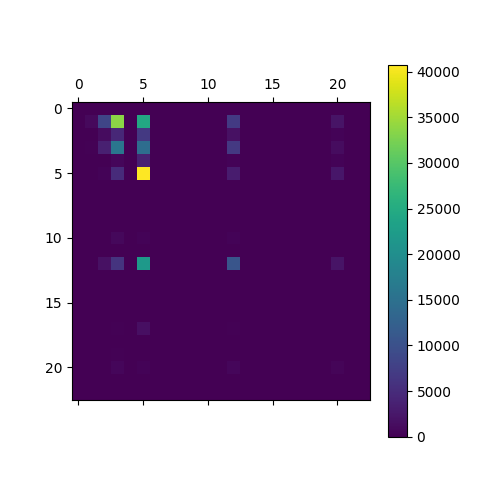

In [48]:
%matplotlib notebook
import matplotlib.pyplot as plt

# Display matrix
plt.matshow(conf_mat)
plt.colorbar()
plt.show()